# がいよー
無限混合ガウスモデルの実装を行う。
ただし、各クラスタに対応する正規分布の平均は
正規分布から生成され、その正規分布の共分散行列は対角行列とする。


# 実装
## 入力するデータ
以下のようなデータを入力する


In [314]:
### ライブラリ
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.utils import shuffle
%matplotlib inline

In [378]:
#### 無限混合ガウスモデル
class DPGMM:
    def __init__(self, data, alpha=1, mu0=0, rho0=1, a0=1, b0=1):
        self.alpha = alpha
        self.mu0 = mu0
        self.rho0 = rho0
        self.a0 = a0
        self.b0 = b0
        
        self._X = data                 #  フィットさせるデータ
        self._N = data.shape[0]        #  全データの個数
        self._D = data.shape[1]        #  各データの次元
        self.new_class = 0             #  新しいクラスタ
        
        # 各データ n が属するクラスタ
        self._Z_n = np.array([0] * self._N) - 1
        self._Z_n[0] = 0
        # 各クラスタ k に属するデータの数
        self._N_k = {self.new_class:1}
        # クラスタに対応したガウス分布の共分散行列(クラスタ共通)
        self._Tau = np.random.gamma(self.a0, 1.0/self.b0)
        # 各クラスタ k に対応したガウス分布の平均
        self._Mu_k = {self.new_class:self._init_gauss_mu()}
    
    ### init mu for gaussian for new class
    def _init_gauss_mu(self):
        tmp_mu = self.mu0 * np.ones(self._D)
        tmp_cov =  1.0/(self._Tau * self.rho0)
        return np.array(np.random.normal(tmp_mu, tmp_cov, self._D))
    
    ### xが多次元の場合のガウス分布の確率密度関数
    ### ただし正規化項はかけていないため、注意
    def _calc_gaussian_pdf(self, x, mu):
        return np.exp((-0.5 / self._Tau) * ((x - mu)**2).sum())
    
    ### sampling z
    def _sampling_z(self):
        for n in range(self._N):
            # 該当するカウンタ減算
            old_k = self._Z_n[n]
            if old_k != -1:
                # クラスタに x_n しかなかった場合
                if old_k not in self._N_k:print("no in _N_k !!!")
                if self._N_k[old_k] == 1:
                    del self._N_k[old_k]
                    del self._Mu_k[old_k]
                else:
                    self._N_k[old_k] -= 1
            
            # p(x | mu_k, tau) を計算。ただし正規化項はkの間で共通のため無視 
            freq1 = [self._calc_gaussian_pdf(self._X[n], self._Mu_k[k]) for k in self._N_k.keys()]
            
            # 新しいクラスタ分も考慮
            new_mu = self._init_gauss_mu()
            freq1.append(self._calc_gaussian_pdf(self._X[n], new_mu))
            freq1 = np.array(freq1)
            
            # 各クラスタに割り当てられる比率。これも正規化項は共通のため無視
            freq2 = list(self._N_k.values())
            freq2.append(self.alpha)
            freq2 = np.array(freq2)
            
            # 各クラスタに割り当てられる確率
            prob = freq1 * freq2
            prob /= prob.sum()
            
            # prob に沿って新しい k のサンプリング
            tmp_classes = list(self._N_k.keys())
            tmp_classes.append(self.new_class)
            new_k = np.random.choice(tmp_classes, p=prob)

            # 新しいクラスタならカウント初期化
            if new_k == self.new_class:
                self._Mu_k[new_k] = new_mu
                self._N_k[new_k] = 0
                
                # 0から順にみて、まだ存在しない最少のjを割り当てる
                tmp_k = 0
                while True:
                    if not tmp_k in self._N_k.keys():
                        self.new_class = tmp_k
                        break
                    tmp_k += 1
            
            # カウント反映
            self._Z_n[n] = new_k
            self._N_k[new_k] += 1
            
    ### calc mean x for sampling mu_k
    def _calc_mean_x(self):
        mean_x_k = {}
        count_k = {}
        for n in range(self._N):
            k = self._Z_n[n]
            if not k in mean_x_k: mean_x_k[k] = 0
            mean_x_k[k] += self._X[n]
        for k in mean_x_k:
            if k in self._N_k.keys():
                mean_x_k[k] /=  self._N_k[k]
        return mean_x_k
    
    ### sampling mu_k
    def _sampling_mu(self):
        # 各クラスタに属するデータの平均
        mean_x_k = self._calc_mean_x()
        for k in self._Mu_k:
            tmp_mu = (self._N_k[k] / (self._N_k[k] + self.rho0))
            tmp_mu *= mean_x_k[k]
            tmp_mu += (self.rho0 / (self._N_k[k] + self.rho0)) * self.mu0
            tmp_cov = (1.0 / (self._Tau * (self._N_k[k] + self.rho0)))
            self._Mu_k[k]  = np.random.normal(tmp_mu, tmp_cov, self._D)
    
    ### sampling tau
    def _sampling_tau(self):
        a = self.a0 + (self._N * self._D)/2.0
        b = self.b0
        mean_x_k = self._calc_mean_x()
        
        for k, n_k in self._N_k.items():
            if n_k == 0: continue
            b += (0.5 * n_k * self.rho0/(self.rho0 + n_k)) * ((mean_x_k[k] - self.mu0)**2).sum()
        for n in range(self._N):
            k = self._Z_n[n]
            b += 0.5 * ((mean_x_k[k] - self.mu0) **2).sum()
        
        self._Tau = np.random.gamma(a, 1.0/b)
    
    ### plot 用
    def plot(self):
        i = 0
        colors = self._colors
        for k, n_k in self._N_k.items():
            if n_k == 0: continue
            assign = [n for n in range(len(self._Z_n)) if self._Z_n[n] == k]
            plt.scatter(self._X[assign, 0], self._X[assign, 1], c=cm.hsv(colors[i]))
            i += 1
        plt.show()
    
    ### データへの適用
    def fit(self, max_iter = 30, plot_iter = 10):
        remained_iter = max_iter
        self._colors = shuffle(np.arange(0, 1, 0.01))
        
        print("iteration start !")
        for ite in range(max_iter):
            ## do iteration
            self._sampling_z()
            self._sampling_mu()
            self._sampling_tau()
            
            ## draw graph
            if((ite % plot_iter) == 0): self.plot()
        print("end!!")
        
        return self

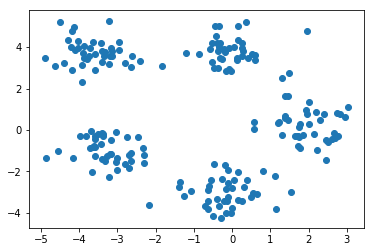

In [374]:
#### 入力するためのデータ生成
mean1 = np.array([0,4])
mean2 = np.array([-3,-1])
mean3 = np.array([2,0])
mean4 = np.array([0,-3])
mean5 = np.array([-3.5,3.8])
conv = np.identity(2) * 0.4

x1 = np.random.multivariate_normal(mean1,conv,(40))
x2 = np.random.multivariate_normal(mean2,conv,(40))
x3 = np.random.multivariate_normal(mean3,conv,(40))
x4 = np.random.multivariate_normal(mean4,conv,(40))
x5 = np.random.multivariate_normal(mean5,conv,(40))

x = np.concatenate([x1,x2,x3,x4,x5],0)
x = shuffle(x)
plt.scatter(x[:,0], x[:,1])

iteration start !


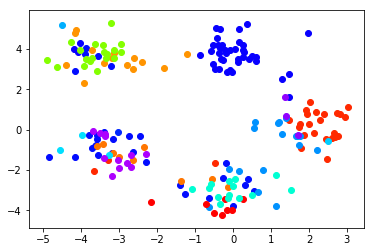

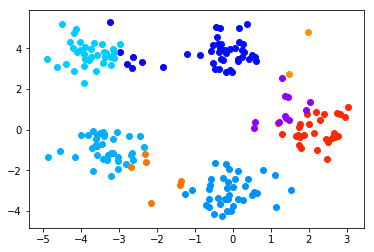

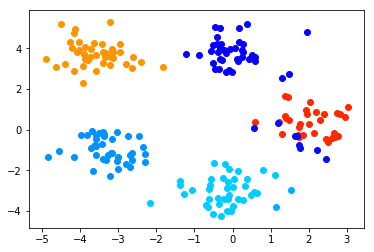

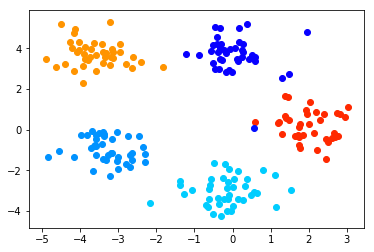

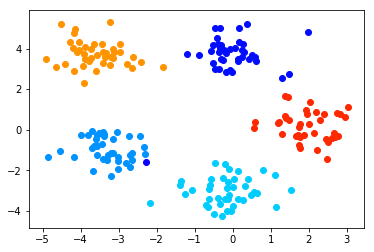

end!!


In [384]:
#### モデル初期化
dpgmm = DPGMM(data=x, alpha=1., mu0=0., rho0=1., a0=1., b0=1.)

#### 推定
dpgmm.fit(max_iter=25, plot_iter=5)

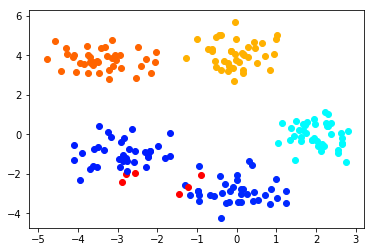

In [368]:
# プロット
Z_n = dpgmm.get_Z_n()
N_k = dpgmm.get_N_k()
i = 0
ci = shuffle(np.arange(0, 1, 0.01))
for k, n_k in N_k.items():
    if n_k == 0: continue
    assign = [n for n in range(len(Z_n)) if Z_n[n] == k]
    plt.scatter(x[assign, 0], x[assign, 1], c=cm.hsv(ci[i]))
    i += 1
plt.show()